                             Analyzing Compliance Issues in PDF Audit Documents Using Clustering                        

Import neccessary libraries

In [2]:
import pandas as pd
import os
import fitz  
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rr14\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rr14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1. Text extraction

In [3]:
# Function to extract text from a PDF file using PyMuPDF
def extract_text_from_pdf(pdf_path):
    text = ''
    doc = fitz.open(pdf_path)
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    doc.close()
    return text

2. Cleaning - "Tokenization", "Lowercasing", "Removing Non-Alphanumeric Characters", "Removing Stopwords" and "Lemmatization".

In [4]:
# Function to clean text using NLTK 
def clean_and_tokenize(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization - reduce words to their root/base form (normalize words)
    porter = PorterStemmer()
    tokens = [porter.stem(token) for token in tokens]
    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

3. Processing extracted text

In [5]:
pdf_directory = 'Audit Data'

# List to store extracted texts and corresponding filenames
texts = []
filenames = []

# Loop through each PDF file in the directory
for filename in os.listdir(pdf_directory):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_directory, filename)
        text = extract_text_from_pdf(pdf_path)
        cleaned_text = clean_and_tokenize(text)
        texts.append(cleaned_text)
        filenames.append(filename)

MuPDF error: syntax error: cannot find XObject resource 'R298'



4. Loading Data

In [6]:
df = pd.DataFrame({'filename': filenames, 'text': texts})

# Assuming 'texts', 'filenames', and 'clusters' are already defined
locations = ['Austria', 'BRUGEL', 'Belgium Federal', 'Flanders', 'Belgium Wallonia', 'Croatia', 'DPCY', 'Czech Republic', 
             'Denmark', 'Estonia', 'Finland', 'France', 'Gasgrid Finland', 'Germany', 'Greece', 'Iceland', 'Ireland', 'GSE', 'Latvia', 
             'Lithuania', 'Luxembourg', 'Netherlands', 'Norway', 'Serbia', 'Slovakia', 'Slovenia', 'GTS Spain', 'Sweden', 
             'Switzerland', 'Portugal', 'DPLV-AST', 'Hungary', 'Spain', 'Belgium']

# Function to extract locations from filename
def extract_locations(filename, locations):
    extracted_locations = []
    for loc in locations:
        # Check if location name is in filename (case insensitive)
        if loc.lower() in filename.lower():  
            extracted_locations.append(loc)
    return extracted_locations

# Apply extraction function to each filename in df
df['locations'] = df['filename'].apply(lambda x: extract_locations(x, locations))
df['locations'] = df['locations'].apply(lambda x: ''.join(x))



In [7]:
df.head()

,filename,text,locations
0,AIB Domain Protocol Energinet Denmark 22-02-2...,eec electr domain protocol denmark prepar ener...,Denmark
1,AIB-2019-DPIT-GSE-Domain Protocol 21-10-2019_0...,eec electr domain protocol itali prepar gestor...,GSE
2,AIB-2019-DPSE-Domain Protocol Sweden version 2...,eec electr domain protocol sweden prepar energ...,Sweden
3,AIB-2020-DPBEB-20200904 Domain Protocol BRUGEL...,127 eec electr domain protocol brussel belgium...,BRUGEL
4,AIB-2020-DPBEF-20200904 Domain Protocol VREG F...,eec electr domain protocol flander prepar vreg...,Flanders


5. Data Transformation - "TF-IDF"

In [8]:
# Vectorize the cleaned text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df['text'])

# Convert the TF-IDF matrix to a DataFrame for better visualization
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

[0.05068656821656082, -0.0021986407007236865, -0.0017328313077264149, -0.0004792877550943077, -0.011797031537372408, -0.011217258274056745, -0.009077800428764524, -0.03387572339709357, -0.03147538384550386]
Optimal number of clusters (Silhouette Score method): 2


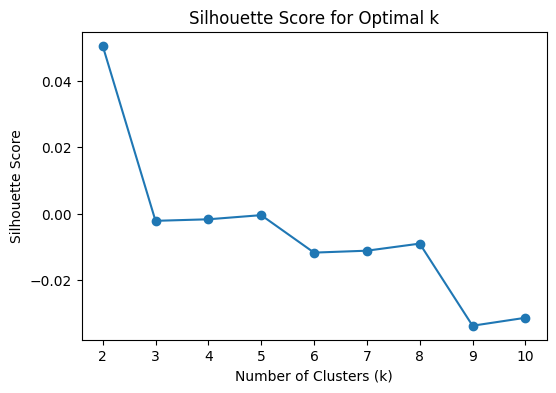

In [9]:
silhouette_scores = []

# To find the optimal 'k' value
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
print(silhouette_scores)

 # +2 because range starts from 2
optimal_k_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2 
print(f'Optimal number of clusters (Silhouette Score method): {optimal_k_silhouette}')

# Plotting the Silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

6. Model fitting - "K-Means"

In [10]:
# KMeans clustering 
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)
df['cluster_label'] = kmeans.fit_predict(X)

# Printing cluster labels for each document
for i, filename in enumerate(filenames):
    print(f"File: {filename}, Cluster: {clusters[i]}")

File: AIB Domain Protocol Energinet Denmark  22-02-2021.pdf, Cluster: 1
File: AIB-2019-DPIT-GSE-Domain Protocol 21-10-2019_0 (1).pdf, Cluster: 1
File: AIB-2019-DPSE-Domain Protocol Sweden version 2.pdf, Cluster: 1
File: AIB-2020-DPBEB-20200904 Domain Protocol BRUGEL - v1.pdf, Cluster: 1
File: AIB-2020-DPBEF-20200904 Domain Protocol VREG Flanders.pdf, Cluster: 1
File: AIB-2020-DPLT-20201208 Domain Protocol Lithuania EECS7_0.pdf, Cluster: 1
File: AIB-2021-DPEE-01 - Estonia - Elering AS Domain Protocol_20210210_clean.pdf, Cluster: 1
File: AIB-2021-DPSI- Domain Protocol Slovenia 2021115.pdf, Cluster: 1
File: AIB-2022-DPCY-Domain Protocol Release 2_clean.pdf, Cluster: 1
File: AIB-2022-DPFI-Domain Protocol Finland 20220325.pdf, Cluster: 1
File: AIB-2022-DPLV-AST Domain Protocol - 20220922.pdf, Cluster: 1
File: AIB-2022-DPNL-VertiCer Netherlands Domain Protocol v3.7 - 20230126.pdf, Cluster: 1
File: AIB-2022-DPPT-REN Portugal Domain Protocol - 22092022.pdf, Cluster: 0
File: AIB-2023-DPAT-E-Con

7. Visualization of clusters - "T-SNE"

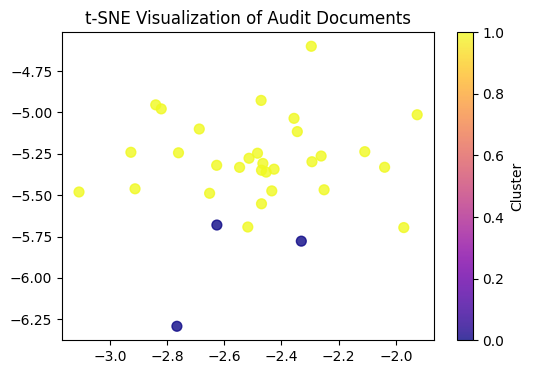

In [11]:
# Reduce dimensionality to 2 dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Plotting clusters
plt.figure(figsize=(6, 4))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='plasma', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of Audit Documents')
plt.show()

8. Cluster summerization

In [12]:
# Summarize each cluster
cluster_summaries = defaultdict(list)
num_clusters = 2
for cluster_label in range(num_clusters):
    cluster_df = df[df['cluster_label'] == cluster_label]
    cluster_text = cluster_df['text']
    
    # Extract keywords using TF-IDF
    cluster_tfidf = vectorizer.transform(cluster_text)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = cluster_tfidf.toarray().sum(axis=0)
    
    # Get top keywords (Top 10)
    top_keywords_idx = tfidf_scores.argsort()[-10:][::-1]  
    top_keywords = [feature_names[idx] for idx in top_keywords_idx]
    
    # Summarize representative documents
    representative_documents = cluster_df['filename'].head(3).tolist() 
    
    # Store cluster summary
    cluster_summary = {
        'Cluster': cluster_label,
        'Top Keywords': top_keywords,
        'Representative Documents': representative_documents
    }
    cluster_summaries[cluster_label] = cluster_summary

for cluster_label, summary in cluster_summaries.items():
    print(f"Cluster {cluster_label}:")
    print(f"Top Keywords: {', '.join(summary['Top Keywords'])}")
    print("Representative Documents:")
    for doc in summary['Representative Documents']:
        print(f"- {doc}")
    print()

Cluster 0:
Top Keywords: eex, ren, die, product, der, devic, de, eego, eec, unspecifi
Representative Documents:
- AIB-2022-DPPT-REN Portugal Domain Protocol - 22092022.pdf
- AIB-2023-DPFR-EEX France Domain Protocol_231120.pdf
- AIB-DP_Switzerland_V0.3_251018_inc_annexes.pdf

Cluster 1:
Top Keywords: eec, product, devic, issu, go, account, certif, domain, electr, energi
Representative Documents:
- AIB Domain Protocol Energinet Denmark  22-02-2021.pdf
- AIB-2019-DPIT-GSE-Domain Protocol 21-10-2019_0 (1).pdf
- AIB-2019-DPSE-Domain Protocol Sweden version 2.pdf



9. Interpretation

In [13]:
df['cluster_label'] = clusters

# Function to analyze compliance issues in each PDF within a cluster
def analyze_compliance_issues(pdf_directory, df, cluster_label):
    cluster_df = df[df['cluster_label'] == cluster_label]
    unique_compliance = set()
    locations_found = set()
    
    for index, row in cluster_df.iterrows():
        pdf_path = os.path.join(pdf_directory, row['filename'])
        text = extract_text_from_pdf(pdf_path)
        
        # Perform compliance issue analysis 
        compliance_keywords = ['violation', 'regulation', 'security']
        
        for keyword in compliance_keywords:
            if keyword in text.lower():
                unique_compliance.add(keyword)
                locations_found.add(row['locations'])  
        
    if unique_compliance:
        print(f"Cluster {cluster_label}:")
        print(f"Number of audit files: {len(cluster_df)}") 
        print(f"Compliance Issues Found: {list(unique_compliance)}")
        print(f"Locations Found: {list(locations_found)}")
        print()

# Analyze compliance issues in each cluster
for cluster_label in range(num_clusters):
    # print(f"Analyzing Cluster {cluster_label}...")
    analyze_compliance_issues(pdf_directory, df, cluster_label)

MuPDF error: syntax error: cannot find XObject resource 'R298'

Cluster 0:
Number of audit files: 3
Compliance Issues Found: ['violation', 'security', 'regulation']
Locations Found: ['France', 'Portugal', 'Switzerland']

Cluster 1:
Number of audit files: 30
Compliance Issues Found: ['violation', 'security', 'regulation']
Locations Found: ['Latvia', 'FinlandGasgrid Finland', 'Hungary', 'GSE', 'Lithuania', 'Belgium WalloniaBelgium', 'GTS SpainSpain', 'Ireland', 'Netherlands', 'Flanders', 'Denmark', 'Croatia', 'Slovenia', 'Germany', 'Norway', 'Serbia', 'BRUGEL', 'Spain', 'Greece', 'DPCY', 'Luxembourg', 'DPLV-AST', 'Czech Republic', 'Sweden', 'Austria', 'Finland', 'Iceland', 'Slovakia', 'Estonia']



10. Evaluation - "Silhouette score"

In [14]:
# Calculate silhouette score
cluster_labels = kmeans.predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.05068656821656082


`Inference`: The low silhouette score (0.05) obtained from K-means clustering with 2 clusters suggests that the algorithm may not effectively capture the underlying patterns in the data.

Hence, exploring alternative clustering techniques such as hierarchical clustering or Gaussian mixture models could provide more meaningful insights.